In [1]:
from minimal_model import ref_parameters, perturbation_steady_state, perturbation_dynamics, \
    I0,  PARAMETER_NAMES, PARAMETER_DESCRIPTIONS, steady_state, change_parameters, jacobian, equation
import numpy as np


In [2]:
from minimal_model import parallel_perturb

In [3]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

In [4]:
# Scaling 

# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 

In [5]:
# Color palate for the K/P models
colors_lipolysis = ['grey', 'lightcoral']
colors_glycolysis = ['grey', 'steelblue']
colors_glycogen = ['grey', 'purple']
colors_ketogenesis = ['grey', 'darkgreen']

In [6]:
perturbations = np.logspace(np.log10(1/3), np.log10(3), 200)
time_dyn = np.linspace(0, 1000, 100)
tol = 1e-4


# Vary KA_glut4
Explore the effect of varying the K_a_glycolysis parameter on the Glucose response to energy expenditure perturbations.

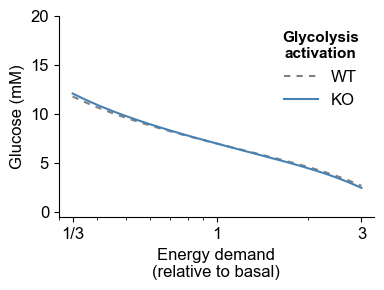

In [7]:
# Compute steady state via dynamics for Vary KA_glut4
X0 = [1.0,1.0,1.0,1.0,I0,I0]
records = []
for ka in [True, False]:
    for v in perturbations:
        p_ka = ref_parameters(K_i_ketogenesis=0.2, insulin_action_glycolysis=ka)
        vE0 = p_ka[PARAMETER_NAMES.index('v_energy')]
        try:
            X_trace, _ = perturbation_dynamics(time_dyn, 1.0, p=p_ka, vE=vE0 * v)
            failed = False
        except Exception:
            records.append({'perturbation': v,
                            'Glucose': np.nan,
                            'steady': False,
                            'failed': True,
                            'K_a_glycolysis': 'WT' if ka else 'KO'})
            continue

        x_end = X_trace.iloc[-1,:-1]
        # Check steady state using model equation
        p_ka_perturbed = p_ka.copy()
        p_ka_perturbed[PARAMETER_NAMES.index('v_energy')] = vE0 * v

        dx = equation(x_end.values, 1.0, p_ka_perturbed)
        steady = np.all(np.abs(dx) < tol)
        records.append({'perturbation': v,
                        'Glucose': x_end['G'] * 7,
                        'steady': steady,
                        'failed': failed,
                        'K_a_glycolysis': 'WT' if ka else 'KO'})
        
pert_ka = pd.DataFrame(records)
# Exclude failed solutions
pert_ka = pert_ka.loc[~pert_ka['failed']].reset_index(drop=True)
# Exclude steady state solutions 
pert_ka = pert_ka.loc[pert_ka['steady']].reset_index(drop=True)

# Plot results
plt.figure(figsize=(4.0,3.0))
sns.lineplot(
    data=pert_ka,
    x='perturbation', y='Glucose',
    hue='K_a_glycolysis', style='K_a_glycolysis',
    palette=colors_glycolysis, linewidth=1.5,
    dashes={'WT': (3,3), 'KO': ()}
)
plt.xlabel('Energy demand\n(relative to basal)')
plt.ylabel('Glucose (mM)')
plt.tight_layout()
# Put legend outside the plot

sns.despine()

# Put legend outside the plot
legend = plt.legend(title='Glycolysis\nactivation', loc='upper right',frameon=False)

legend_title = legend.get_title()
legend_title.set_fontweight('bold')
legend_title.set_fontsize(11)
legend_title.set_ha('center') # Aligns the title to the left

plt.xlim(1/3 * 0.9, 3 * 1.1)
plt.xscale('log')
plt.xticks([1/3 , 1, 3 ], ['1/3','1','3'])
plt.ylim(-0.5, 20)

# Save the figure as svg
plt.savefig('output/insulin_action_glycolysis.svg', format='svg', bbox_inches='tight')

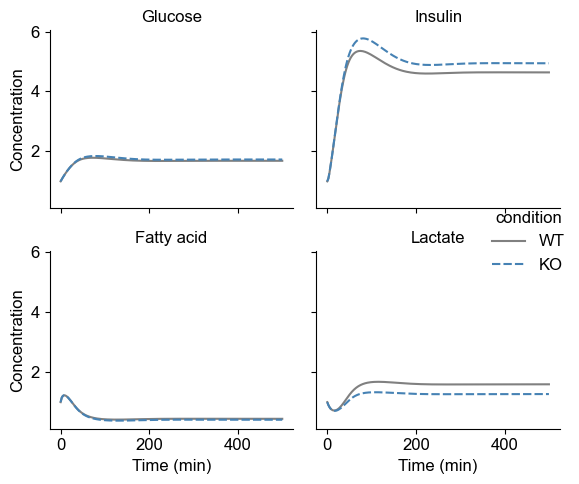

In [8]:
# Time traces at low energy expenditure for glycolysis KO and WT using seaborn grid
import pandas as pd

time = np.linspace(0, 500, 200)
ka_values = [True, False]
species = ['G','I','F','L']  # Glucose, Insulin, Fatty acid, Lactate
records = []
for ka in ka_values:
    condition = 'WT' if ka else 'KO'
    p_ka = ref_parameters(K_i_ketogenesis=0.2, insulin_action_glycolysis=ka)
    vE_low = p_ka[PARAMETER_NAMES.index('v_energy')] * (1/3)
    X_ka, _ = perturbation_dynamics(time, 1.0, p=p_ka, vE=vE_low)
    df_melt = X_ka.melt(id_vars='time', value_vars=species, var_name='species', value_name='concentration')
    df_melt['condition'] = condition
    records.append(df_melt)
dyn_df = pd.concat(records, ignore_index=True)
dyn_df['species_label'] = dyn_df['species'].map({'G':'Glucose','I':'Insulin','F':'Fatty acid','L':'Lactate'})

# Normalize insulin by I0
dyn_df.loc[dyn_df['species'] == 'I', 'concentration'] /= I0

g = sns.relplot(
    data=dyn_df,
    x='time', y='concentration',
    hue='condition', style='condition',
    kind='line', col='species_label', col_wrap=2,
    height=2.5, aspect=1,
    palette=colors_glycolysis
)
g.set_axis_labels('Time (min)','Concentration')
g.set_titles('{col_name}')
plt.tight_layout()
#plt.savefig('insulin_action_glycolysis_dynamics.svg', format='svg', bbox_inches='tight')

# Vary KI_GL
Explore the effect of varying the K_i_glycogenolysis parameter on the Glucose response to energy expenditure perturbations.

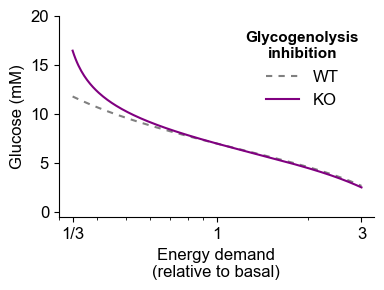

In [9]:
# Compute steady state via dynamics for Vary KI_GL
time_dyn = np.linspace(0, 1000, 50)
tol = 1e-4
records = []
for ki in [True, False]:
    for v in perturbations:
        p_ki = ref_parameters(K_i_ketogenesis=0.2, with_GL=ki)
        vE0 = p_ki[PARAMETER_NAMES.index('v_energy')]
        try:
            X_trace, _ = perturbation_dynamics(time_dyn, 1.0, p=p_ki, vE=vE0 * v)
            failed = False
        except Exception:
            records.append({'perturbation': v,
                            'Glucose': np.nan,
                            'steady': False,
                            'failed': True,
                            'K_i_glycogenolysis': 'WT' if ki else 'KO'})
            continue

        x_end = X_trace.iloc[-1,:-1]
    
        # Check steady state using model equation on perturbed vE
        p_ki_perturbed = p_ki.copy()
        p_ki_perturbed[PARAMETER_NAMES.index('v_energy')] = vE0 * v
        dx = equation(x_end.values, 1.0, p_ki_perturbed)
        steady = np.all(np.abs(dx) < tol)
        records.append({'perturbation': v,
                        'Glucose': x_end['G'] * 7,
                        'steady': steady,
                        'failed': failed,
                        'K_i_glycogenolysis': 'WT' if ki else 'KO'})
        
pert_ki = pd.DataFrame(records)
# Exclude failed solutions
pert_ki = pert_ki.loc[~pert_ki['failed']].reset_index(drop=True)
# Exclude non steady state solution
pert_ki = pert_ki.loc[pert_ki['steady']].reset_index(drop=True)

# Plot results
plt.figure(figsize=(4.0,3.0))
sns.lineplot(
    data=pert_ki,
    x='perturbation', y='Glucose',
    hue='K_i_glycogenolysis', style='K_i_glycogenolysis',
    palette=colors_glycogen, linewidth=1.5,
    dashes={'WT': (3,3), 'KO': ()}
)
plt.xlabel('Energy demand\n(relative to basal)')
plt.ylabel('Glucose (mM)')
plt.tight_layout()
sns.despine()

legend = plt.legend(title='Glycogenolysis\ninhibition', loc='upper right', frameon=False)
legend_title = legend.get_title()
legend_title.set_fontweight('bold')
legend_title.set_fontsize(11)
legend_title.set_ha('center') 

plt.xlim(1/3* 0.9, 3*1.1)
plt.xscale('log')
plt.xticks([1/3 , 1, 3 ], ['1/3','1','3'])
plt.ylim(-0.5, 20)
# Save the figure as svg
plt.savefig('output/insulin_action_glycogen.svg', format='svg', bbox_inches='tight')

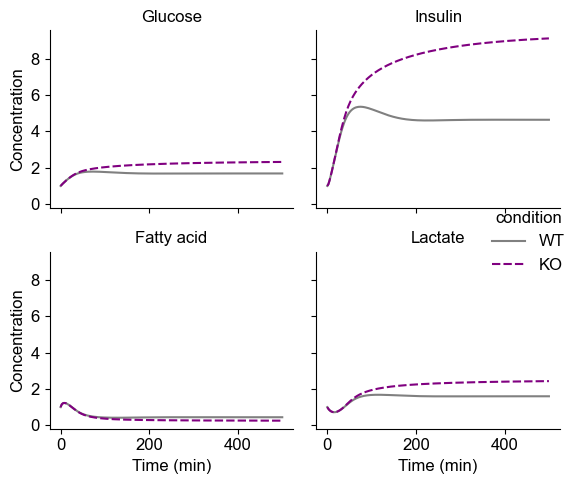

In [10]:
# Time traces at low energy expenditure for glycogen KO and WT using seaborn grid
import pandas as pd

ki_values = [True, False]
species = ['G','I','F','L']  # Glucose, Insulin, Fatty acid, Lactate
records = []
for ki in ki_values:
    condition = 'WT' if ki else 'KO'
    p_ki = ref_parameters(K_i_ketogenesis=0.2, with_GL=ki)
    vE_low = p_ki[PARAMETER_NAMES.index('v_energy')] * (1/3)
    X_ki, _ = perturbation_dynamics(time, 1.0, p=p_ki, vE=vE_low)
    df_melt = X_ki.melt(id_vars='time', value_vars=species, var_name='species', value_name='concentration')
    df_melt['condition'] = condition
    records.append(df_melt)
dyn_df = pd.concat(records, ignore_index=True)
dyn_df['species_label'] = dyn_df['species'].map({'G':'Glucose','I':'Insulin','F':'Fatty acid','L':'Lactate'})

# Normalize insulin by I0
dyn_df.loc[dyn_df['species'] == 'I', 'concentration'] /= I0

g = sns.relplot(
    data=dyn_df,
    x='time', y='concentration',
    hue='condition', style='condition',
    kind='line', col='species_label', col_wrap=2,
    height=2.5, aspect=1,
    palette=colors_glycogen
)
g.set_axis_labels('Time (min)','Concentration')
g.set_titles('{col_name}')
plt.tight_layout()


# Vary KI_lipo
Explore the effect of varying the K_i_lipolysis parameter on the Glucose response to energy expenditure perturbations.

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5447817673782D+02   r2 =  0.2232247667632D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5447817673782D+02   r2 =  0.2790309584539D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5447817673782D+02   r2 =  0.2790309584539D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5447817673782D+02   r2 =  0.5580619169079D-15
 lsoda--  warning..internal t (=r1) 

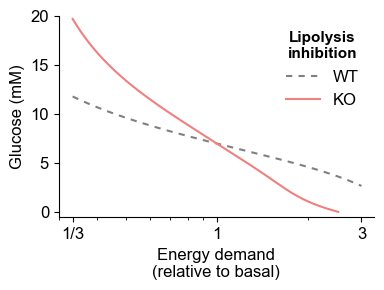

In [11]:
# Compute steady state via dynamics for Vary KI_lipo

records = []
for li in [True, False]:
    for v in perturbations:
        p_li = ref_parameters(K_i_ketogenesis=0.2, insulin_action_lipolysis=li)
        vE0 = p_li[PARAMETER_NAMES.index('v_energy')]
        try:
            X_trace, _ = perturbation_dynamics(time_dyn, 1.0, p=p_li, vE=vE0 * v)
            failed = False
        except Exception:
            records.append({'perturbation': v,
                            'Glucose': np.nan,
                            'steady': False,
                            'failed': True,
                            'K_i_lipolysis': 'WT' if li else 'KO'})
            continue
        x_end = X_trace.iloc[-1,:-1]
        # Check steady state using model equation
        p_li_perturbed = p_li.copy()
        p_li_perturbed[PARAMETER_NAMES.index('v_energy')] = vE0  * v
        # Check steady state using model equation
        dx = equation(x_end.values, 1.0, p_li_perturbed)
        steady = np.all(np.abs(dx) < tol)
        records.append({'perturbation': v,
                        'Glucose': x_end['G'] * 7,
                        'steady': steady,
                        'failed': failed,
                        'K_i_lipolysis': 'WT' if li else 'KO'})
pert_lipo = pd.DataFrame(records)
# Exclude failed solutions
pert_lipo = pert_lipo.loc[~pert_lipo['failed']].reset_index(drop=True)
# Exlcude non steady state solutions
pert_lipo = pert_lipo.loc[pert_lipo['steady']].reset_index(drop=True)

# Plot results
g = plt.figure(figsize=(4.0,3.0))
sns.lineplot(
    data=pert_lipo,
    x='perturbation', y='Glucose',
    hue='K_i_lipolysis', style='K_i_lipolysis',
    palette=colors_lipolysis, linewidth=1.5,
    dashes={'WT': (3,3), 'KO': ()}
)
plt.xlabel('Energy demand\n(relative to basal)')
plt.ylabel('Glucose (mM)')
plt.tight_layout()
sns.despine()

legend = plt.legend(title='Lipolysis\ninhibition', loc='upper right', frameon=False)
legend_title = legend.get_title()
legend_title.set_fontweight('bold')
legend_title.set_fontsize(11)
legend_title.set_ha('center') # Aligns the title to the left
plt.xlim(1/3*0.9, 3*1.1)
plt.xscale('log')
plt.xticks([1/3, 1, 3], ['1/3', '1', '3'])
plt.ylim(-0.5, 20)
plt.savefig('./output/insulin_action_lipolysis.svg', format='svg', bbox_inches='tight')

In [12]:
pert_lipo

,perturbation,Glucose,steady,failed,KI_lipo
0,0.333333,11.800234,True,False,WT
1,0.337034,11.729241,True,False,WT
2,0.340776,11.659105,True,False,WT
3,0.344560,11.589804,True,False,WT
4,0.348385,11.521318,True,False,WT
...,...,...,...,...,...
379,2.405567,0.211373,True,False,KO
380,2.432275,0.168956,True,False,KO
381,2.459279,0.127458,True,False,KO
382,2.486584,0.086839,True,False,KO


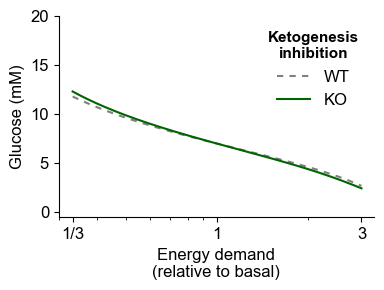

In [13]:
# Compute steady state via dynamics for Vary KI_F
time_dyn = np.linspace(0, 500, 5001)
tol = 1e-6
records = []
for fi in [True, False]:
    p_f = ref_parameters(K_i_ketogenesis=0.2, insulin_action_ketogenesis=fi)
    vE0_f = p_f[PARAMETER_NAMES.index('v_energy')]
    for v in perturbations:
        try:
            X_trace, _ = perturbation_dynamics(time_dyn, 1.0, p=p_f, vE=vE0_f * v)
            failed = False
        except Exception:
            records.append({'perturbation': v,
                            'Glucose': np.nan,
                            'steady': False,
                            'failed': True,
                            'K_i_ketogenesis': 'WT' if fi else 'KO'})
            continue
        x_end = X_trace.iloc[-1,1:]
        # Check steady state using model equation
        p_f_perturbed = p_f.copy()
        p_f_perturbed[PARAMETER_NAMES.index('v_energy')] = vE0_f * v
        # Check steady state using model equation
        dx = equation(x_end.values, 1.0, p_f_perturbed)
        steady = np.all(np.abs(dx) < tol)
        records.append({
            'perturbation': v,
            'Glucose': x_end['G'] * 7,
            'steady': steady,
            'failed': failed,
            'K_i_ketogenesis': 'WT' if fi else 'KO'
        })
pert_f = pd.DataFrame(records)
# Exclude failed solutions
pert_f = pert_f.loc[~pert_f['failed']].reset_index(drop=True)

# Plot results
plt.figure(figsize=(4.0,3.0))
sns.lineplot(
    data=pert_f,
    x='perturbation', y='Glucose',
    hue='K_i_ketogenesis', style='K_i_ketogenesis',
    palette=colors_ketogenesis, linewidth=1.5,
    dashes={'WT': (3,3), 'KO': ()}
)
plt.xlabel('Energy demand\n(relative to basal)')
plt.ylabel('Glucose (mM)')
plt.tight_layout()
sns.despine()

legend = plt.legend(title='Ketogenesis\ninhibition', loc='upper right', frameon=False, )
legend_title = legend.get_title()
legend_title.set_fontweight('bold')
legend_title.set_fontsize(11)
legend_title.set_ha('center') # Aligns the title to the left

plt.xlim(1/3*0.9, 3*1.1)
plt.xscale('log',)
plt.xticks([1/3, 1, 3], ['1/3', '1', '3'])
plt.ylim(-0.5, 20)
plt.savefig('output/insulin_action_ketogenesis.svg', format='svg', bbox_inches='tight')